In [15]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [16]:
# Step 1 - Loading and checking the dataset
penguins_df = pd.read_csv("data/penguins.csv")
penguins_df.head()
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


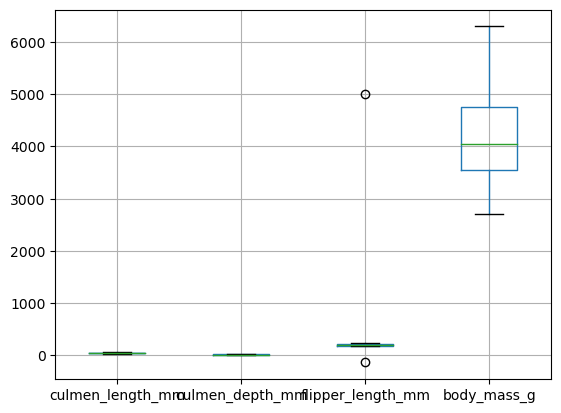

Total number of outliers across all features: 2
Indexes of outliers: [9, 14]


In [17]:
# Step 2 - Dealing with null values and outliers
penguins_df.boxplot()  
plt.show()

# Outlier detection with percentiles
outlier_indexes = set()  # Use a set to avoid duplicate indexes

# Loop over each numeric feature in the DataFrame
for feature in penguins_df.select_dtypes(include=['number']).columns:
    # Calculate the 25th and 75th percentiles for each feature
    q1 = penguins_df[feature].quantile(0.25)
    q3 = penguins_df[feature].quantile(0.75)
    
    # Find the IQR for each feature
    IQR = q3 - q1
    factor = 2.5  
    
    # Calculate the lower and upper limits for outliers for each feature
    lower_limit = q1 - (IQR * factor)
    upper_limit = q3 + (IQR * factor)
    
    # Create a mask for values lower than lower_limit and higher than upper_limit for each feature
    outlier_mask = (penguins_df[feature] < lower_limit) | (penguins_df[feature] > upper_limit)
    
    # Update the outlier_indexes set with the indexes for outliers for each feature
    feature_outliers = penguins_df[outlier_mask].index
    outlier_indexes.update(feature_outliers)

# Convert the set to a list to use for dropping the rows
outlier_indexes = list(outlier_indexes)

# Print the number of outliers and their indexes
print(f"Total number of outliers across all features: {len(outlier_indexes)}")
print(f"Indexes of outliers: {outlier_indexes}")

#Drop and clean
penguins_clean = penguins_df.dropna()
penguins_clean[penguins_clean['flipper_length_mm']>4000]
penguins_clean[penguins_clean['flipper_length_mm']<0]
penguins_clean = penguins_clean.drop([9,14])

In [18]:
# Step 3 - Dummy variables
df = pd.get_dummies(penguins_clean).drop('sex_.',axis=1)

In [19]:
# Step 4 - Scaling
scaler = StandardScaler()
X = scaler.fit_transform(df)
penguins_preprocessed = pd.DataFrame(data=X,columns=df.columns)
penguins_preprocessed.head(10)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_FEMALE,sex_MALE
0,-0.905520,0.793126,-1.428125,-0.569709,-0.991031,0.997001
1,-0.831938,0.128503,-1.071522,-0.507579,1.009050,-1.003008
2,-0.684775,0.435252,-0.429637,-1.191006,1.009050,-1.003008
3,-1.347011,1.099875,-0.572278,-0.942487,1.009050,-1.003008
4,-0.868729,1.764498,-0.786240,-0.693968,-0.991031,0.997001
5,-0.942311,0.333002,-1.428125,-0.725033,1.009050,-1.003008
6,-0.887125,1.253249,-0.429637,0.579691,-0.991031,0.997001
7,-0.537611,0.230753,-1.356804,-1.253136,1.009050,-1.003008
8,-0.997497,2.071247,-0.714919,-0.507579,-0.991031,0.997001
9,-1.365406,0.333002,-1.142843,-0.631839,1.009050,-1.003008


In [20]:
# Step 5 - PCA - features selection
pca = PCA(n_components=None)
dfx_pca = pca.fit(penguins_preprocessed)
dfx_pca.explained_variance_ratio_
n_components=sum(dfx_pca.explained_variance_ratio_>0.1)
pca = PCA(n_components=n_components)
penguins_PCA = pca.fit_transform(penguins_preprocessed)

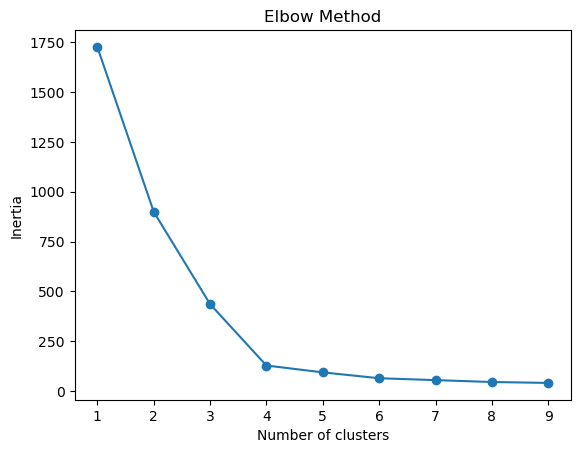

In [21]:
# Step 6 - Detect the optimal number of clusters for k-means clustering
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(penguins_PCA)
    inertia.append(kmeans.inertia_)    
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()
n_clusters=4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


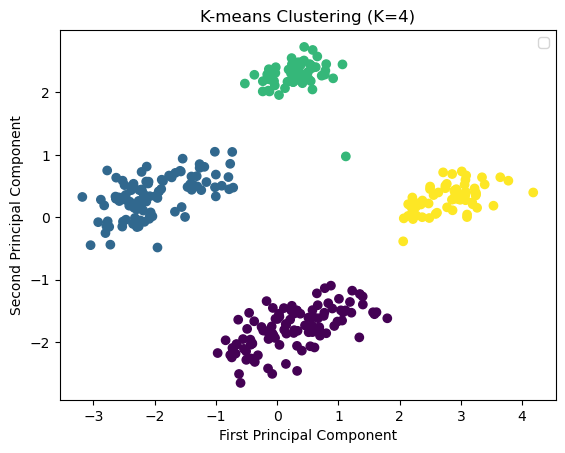

In [22]:
# Step 7 - Run the k-means clustering algorithm

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(penguins_PCA)
plt.scatter(penguins_PCA[:, 0], penguins_PCA[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-means Clustering (K={n_clusters})')
plt.legend()
plt.show()

In [23]:
# Step 8 - Statistical DataFrame for each cluster.
penguins_clean['label'] = kmeans.labels_
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm','label']
stat_penguins = penguins_clean[numeric_columns].groupby('label').mean()
stat_penguins

,culmen_length_mm,culmen_depth_mm,flipper_length_mm
label,,,
0,43.878302,19.111321,194.764151
1,40.217757,17.611215,189.046729
2,45.545763,14.262712,212.779661
3,49.473770,15.718033,221.540984
